**This project employed the use of Wikipedia and Reddit data to track changes in a Wikipedia page over time. Data from Reddit was used in a TF-IDF and sentiment analysis. Deletions and changes in edits were tracked on Wikipedia through a text analysis.**

# **Section 1: Wikipedia**

# 1.1 Data Retrieval

In [1]:
## Read in Warsaw Concentration Camp page from Wikipedia to .xml 
## Read in 1000 revisions beginning with January 1, 2019
## FSDS_W4_2_Working_with_APIs

fileout = "Warsaw.xml"

## Set offset to January 1, 2019 to retrieve all of the revisions for the 2019 year
## There were 230 revisions for the 2019 calendar year at the time of this analysis

curl_query = '''
curl -d "&pages={}&action=submit&limit=1000&offset=20190101003006" https://en.wikipedia.org/w/index.php?title=Special:Export -o "{}"
'''.format("Warsaw concentration camp",fileout)

print(curl_query)

#import os

#os.system(curl_query)


curl -d "&pages=Warsaw concentration camp&action=submit&limit=1000&offset=20190101003006" https://en.wikipedia.org/w/index.php?title=Special:Export -o "Warsaw.xml"



# 1.2 Read Wikipedia data

In [2]:
## xmltodict notation: https://www.journaldev.com/19392/python-xml-to-json-dict

import xmltodict
import pprint
import json
from pandas.io.json import json_normalize
import pandas as pd


pd.set_option('display.max_colwidth', 200)
#pd.set_option('display.width', 1000)


## Read in .xml to .json file

with open('Warsaw.xml', encoding = "utf8") as fd:
    doc = xmltodict.parse(fd.read())
    
with open("Warsaw", "w") as file_new:
    json.dump(doc,file_new)

with open("Warsaw", "r") as file_new:
    new = json.load(file_new)
    
## Normalize to pandas dataframe

final = json_normalize(new["mediawiki"]["page"]["revision"])
#display(type(final))
#display(final)
 

FileNotFoundError: [Errno 2] No such file or directory: 'Warsaw.xml'

# 1.3 Compare Revision Data Across Specific Dates

In [3]:
new_df = final.copy()

new_df["text.#text"]== new_df["text.#text"].astype(str)


## Search for the word conspiracy and Poles within text body 
## 18 is where the change occurs 

df1 = new_df['text.#text'].str.contains("conspiracy")
#print(df1[:50]) 

df2 = new_df['text.#text'].str.contains("Poles")
#print(df2[:50])


## Pre-Notice of the False History on this Page 
## First post of the 2019 year

January  = final[final["timestamp"]== "2019-01-17T15:18:54Z"]
January_text = January["text.#text"].iloc[0]

    
## Post-Notice of the False History on this Page 

August28_2= final[final["timestamp"]== "2019-08-28T06:46:10Z"]
August28_text = August28_2["text.#text"].iloc[0]

    
## Most recent update as of November 16,2019
  
November14 = final[final["timestamp"]== "2019-11-14T07:12:14Z"]
November14_text = November14["text.#text"].iloc[0]
 
    
## Pulled revision from day of election, October 13, 2019

October13 = final[final["timestamp"] == "2019-10-13T08:30:13Z"]
October13_text = October13["text.#text"].iloc[0]

# 1.4 Run Text Analysis Using Deltas

In [3]:
## code quoted from https://pythonhosted.org/deltas/
## Run text comparison of insertions, deletions and equal text

from deltas import segment_matcher, text_split

def textComparison(data1, data2):

    a = text_split.tokenize(data1)
    b = text_split.tokenize(data2)
    operations = segment_matcher.diff(a, b)

    for op in operations:
        print(op.name, repr(''.join(a[op.a1:op.a2])),
        repr(''.join(b[op.b1:op.b2])))
    

#textComparison(January_text, August28_text)

#textComparison(August28_text, October13_text)

#textComparison(January_text, November14_text)




# 1.5 Visualization of Word Occurrence from Wikipedia Data

Count    7.52381
Month    8.00000
dtype: float64

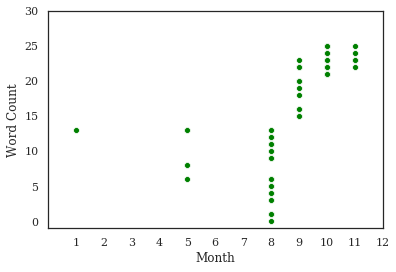

In [6]:
## Plot frequency and variation of the word "Polish" across 11 months

import seaborn as sns
import matplotlib.pyplot as plt

## Define function that counts number of occurrences of specific word in body text


def countOccurrences(word, sentence):
    return sentence.count(word)



new_df["text.#text"] = new_df["text.#text"].apply(str)

## Use count Occurrences function to count frequency of the word "Polish" in all 230 rows of body text.

count = {}
time_list = []
count_list= []
for i in range(0, len(new_df)):
    text = new_df.loc[i,"text.#text"]
    time = new_df.loc[i,"timestamp"]
    freq = countOccurrences("Polish", text)
    time_list.append(time)
    count_list.append(freq)


#display(len(time_list))

counts = pd.DataFrame((zip(time_list, count_list)), columns =['Time', 'Count']) 
#display(counts)


## Convert timestamp from Wikipedia into datetime and take month from each of the rows 

counts['datetime'] =  pd.to_datetime(counts['Time'], format="%Y-%m-%dT%H:%M:%SZ")
counts['Month'] = counts['datetime'].dt.month
counts = counts[:-1]
#display(counts.sort_values(by = "Time", ascending = True)[:30])


## Set style of plot
def set_style():
    sns.set_context("paper")
    sns.set(font='serif')
    sns.set_style("white", {
        "font.family": "serif",
        "font.serif": ["Times", "Palatino", "serif"]
    })

## Calculate mean for month of August 

count1 = counts[counts["Month"] == 8].mean()


display(count1)

## Create scatterplot for variation in the count of word "Polish" for each month across 11 months 

set_style()
ax= sns.scatterplot(x= "Month", y= "Count", data= counts, color = "green")
ax.set_xlim(0,12)
ax.set_ylim(-1,30)
ax.set_xticks([1,2,3,4,5,6,7,8,9,10, 11, 12])
ax.set_xlabel("Month")
ax.set_ylabel("Word Count")
ax.figure.savefig('Polish_time.png',  dpi=2000, bbox_inches = "tight")
ax



     

# 1.6 Visualization of Frequency of Wikipedia Revisions

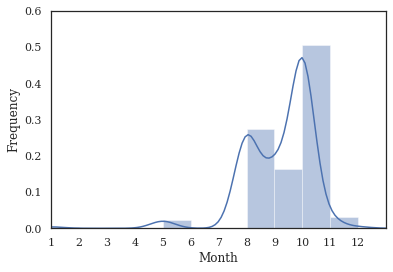

In [7]:
##Create plot of number of revision dates


## Find number of revisions per month using datetime

new_df['datetime'] =  pd.to_datetime(new_df['timestamp'], format="%Y-%m-%dT%H:%M:%SZ")

new_df["month"] = new_df["datetime"].dt.month


set_style()


ax2 = sns.distplot(new_df["month"], bins = 11)
ax2.set_xlim(1,13)
ax2.set_ylim(0,.6)
ax2.set_xlabel("Month")
ax2.set_ylabel("Frequency")
ax2.set_xticks([1,2,3,4,5,6,7,8,9,10, 11,12])


plt.savefig('RevisionData.png',dpi=2000, bbox_inches = "tight")



# **Section 2: Reddit**

# 2.1 Data Retrieval

In [5]:
## Based on FSDS_4_1_Getting_Web_Data_from_Reddit


import json
from pandas.io.json import json_normalize

try: 
    import praw
except ModuleNotFoundError:
    import sys
    !{sys.executable} -m pip install praw
    import praw
    
## keys.json was created and stores user specific client_id, client_secret, username, and password

## load JSON into Python with Reddit API user information

keys = json.loads(open("keys.json").read())

## Check for correct login and user account through OAuth

reddit = praw.Reddit(user_agent='Comment Extraction (by /u/	pythonsummative)',
                     client_id=keys['client_id'], 
                     client_secret=keys['client_secret'],
                     username=keys['username'], 
                     password=keys['password'])



# 2.2  Read Reddit Data

In [6]:
## Based on FSDS_4_1_Getting_Web_Data_from_Reddit


## Pull three Reddit posts 

post1 = reddit.submission(url="https://www.reddit.com/r/worldnews/comments/dhf15n/polands_nationalist_law_and_justice_party/")
post2 = reddit.submission(url='https://www.reddit.com/r/worldnews/comments/bbz49b/polish_senator_says_nation_should_be_purged_of/')
post3 = reddit.submission(url= 'https://www.reddit.com/r/worldnews/comments/akb64f/polish_nationalists_march_on_auschwitz_to_protest/')


## creation of function for reading in Reddit posts and creating dataframes from them

def dfCreation(post):
    df_list = []
    flag = True 
    for c,comment in enumerate(post.comments.list()):
        
        ## Both try statements exist due to previous deletions of both user accounts and comments
        ## If they have been deleted, "[deleted]" will be assigned accordingly
        
        try:
            x = comment.author.name,
            authorname = x[0]
        except AttributeError:
            authorname = "[deleted]"

        try:
            comment_body = comment.body,
        except AttributeError:
            comment_body = "[deleted]"
            
        ## Grab id, body, authorname, upvotes, created timestamp, depth,parent id, subreddit, and is_submitter from every Reddit comment and subcomment

        try: 
            df_list.append([ \
            comment.id,
            comment_body,
            authorname,
            comment.ups,
            comment.created_utc,
            comment.depth,
            comment.parent_id[3:],
            comment.subreddit, 
            comment.is_submitter,   
            ])
        except AttributeError:
            if flag: 
                flag = True

    df = pd.DataFrame(df_list,columns=["id","body","authorname","ups","created_utc","depth","parent_id", "subreddit","submitter_ID"])
    return df

## Run function to load in Reddit posts

reddit_df = dfCreation(post1)
#display(reddit_df)
reddit_df2 = dfCreation(post2)
#display(reddit_df2)
reddit_df3 = dfCreation(post3)
#display(reddit_df3)
    


# 2.3 Analyze upvotes on three Reddit posts

In [7]:
## Display 10 comments for most and least upvotes for each of the three Reddit posts 

#display(reddit_df.sort_values(by = "ups",ascending=False)[:10])
#display(reddit_df.sort_values(by = "ups",ascending=True)[:10])

#display(reddit_df2.sort_values(by = "ups",ascending=False)[:10])
#display(reddit_df2.sort_values(by = "ups",ascending=True)[:10])

#display(reddit_df3.sort_values(by = "ups",ascending=False)[:10])
#display(reddit_df3.sort_values(by = "ups",ascending=True)[:10])




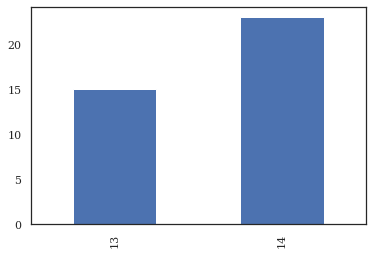

In [17]:
## Additional visualizations of when comments were made across days and months for each post

from datetime import datetime 

reddit_df["utc"] = reddit_df["created_utc"].map(lambda x: datetime.utcfromtimestamp(x) )
reddit_df2["utc"] = reddit_df2["created_utc"].map(lambda x: datetime.utcfromtimestamp(x) )
reddit_df3["utc"] = reddit_df3["created_utc"].map(lambda x: datetime.utcfromtimestamp(x) )

#display(reddit_df)

## Plot displaying revision days in October, signaling the revisions were made on election day and the day after

reddit_df["utc"].dt.day.value_counts().sort_index().plot.bar()
#reddit_df2["utc"].dt.month.value_counts().sort_index().plot.bar()
#reddit_df3["utc"].dt.day.value_counts().sort_index().plot.bar()

# 2.4 Top Words Analysis: TF-IDF

In [18]:
## Based on FSDS_w_3_1_NLPandasSQL


import nltk
# nltk.download('punkt')
from nltk import word_tokenize
from nltk.stem.porter import PorterStemmer

## Stop-word packages

# nltk.download('stopwords')
from nltk.corpus import stopwords
stopWords = set(stopwords.words('english'))

## TF-IDF packages

from sklearn.feature_extraction.text import TfidfVectorizer

def tokenize(text,remove_stop=True, lower=True, sep=" "):
    
    if lower: text = text.lower() 
        
    ## Separate text by space using word_tokenize 
        
    tokens = word_tokenize(text) 
    stems = []
    
    ## remove stopwords and find stem words 
    
    for item in tokens:          
        if remove_stop:           
            if item not in stopWords:  stems.append(PorterStemmer().stem(item))
        else:
            stems.append(PorterStemmer().stem(item))
    return sep.join(stems)

## make sure dataframes contain strings as data type for further sentiment analysis 

reddit_df = reddit_df.applymap(str)
reddit_df2 = reddit_df2.applymap(str)
reddit_df3 = reddit_df3.applymap(str)

vectorizer = TfidfVectorizer()

## apply tokenize function to text body 
## TFIDF anaylsis to see how important a word is in a document, using TfidVectorizer
## Sort values by the most important words per the TFIDF analysis

reddit_df["token_clean_body"] = reddit_df["body"].map(lambda body: tokenize(body))
matrix = vectorizer.fit_transform(reddit_df["token_clean_body"]).todense()
matrix_df = pd.DataFrame(matrix, columns=vectorizer.get_feature_names())
top_words = matrix_df.sum(axis=0).sort_values(ascending=False)

reddit_df2["token_clean_body"] = reddit_df2["body"].map(lambda body: tokenize(body))
matrix2 = vectorizer.fit_transform(reddit_df2["token_clean_body"]).todense()
matrix_df2 = pd.DataFrame(matrix2, columns=vectorizer.get_feature_names())
top_words2 = matrix_df2.sum(axis=0).sort_values(ascending=False)

reddit_df3["token_clean_body"] = reddit_df3["body"].map(lambda body: tokenize(body))
matrix3 = vectorizer.fit_transform(reddit_df3["token_clean_body"]).todense()
matrix_df3 = pd.DataFrame(matrix3, columns=vectorizer.get_feature_names())
top_words3 = matrix_df3.sum(axis=0).sort_values(ascending=False)




In [19]:
## Show the top 10 words for each of the three Reddit posts 

display(top_words[:10])
#display(top_words2[:10])
#display(top_words3[:10])

right     2.028508
delet     2.000000
parti     1.746575
peopl     1.606254
poland    1.522230
vote      1.473594
russia    1.450845
far       1.442111
sure      1.269104
social    1.204926
dtype: float64

# 2.5 Sentiment Analysis

In [20]:
try: 
    import vaderSentiment
except ModuleNotFoundError:
    import sys
    !{sys.executable} -m pip install vaderSentiment
    import vaderSentiment

In [21]:
## Sentiment Analysis - VADER
## Based on FSDS_w_3_1_NLPandasSQL


from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

analyzer = SentimentIntensityAnalyzer()

## Create a function that scores each sentence and creates a column for positive, negative, neutral and compound scores

def Senti(df):
    
    ## Analyze polarity of each word in token_clean_body of dataframe

    df["sentiment_cl"] = df["token_clean_body"].map(
        lambda bodytext: analyzer.polarity_scores(bodytext))


    df["senti_pos"] = df["sentiment_cl"].map(lambda x: x["pos"])
    df["senti_neg"] = df["sentiment_cl"].map(lambda x: x["neg"])
    df["senti_neu"] = df["sentiment_cl"].map(lambda x: x["neu"])
    df["senti_compound"] = df["sentiment_cl"].map(lambda x: x["compound"])
    
    ## Remove redundant column

    del df["sentiment_cl"] 
    

Senti(reddit_df)
Senti(reddit_df2)
Senti(reddit_df3)

# 2.6 Re-label Sentiment Scores 

In [22]:
## Define function for assigning labels to senti compound scores

def sentiOutput(df_senti):
    score = []
    try :
        for row in df_senti["senti_compound"]: 
            if row < -.05 :
                score.append("Negative")
            elif row > .05:
                score.append("Positive")
            else : 
                score.append("Neutral")
    except : 
        score.append("Unknown")
    #print(len(score))
    
    df_senti["Score"]= score
    return df_senti

    #display(df_senti)
    
reddit_df_senti = sentiOutput(reddit_df)
#display(reddit_df_senti)

reddit_df_senti2 = sentiOutput(reddit_df2)
#display(reddit_df_senti2)

reddit_df_senti3 = sentiOutput(reddit_df3)
#display(reddit_df_senti3)



# 2.7 Sentiment Analysis Visualization Using Top Words from 3 Posts

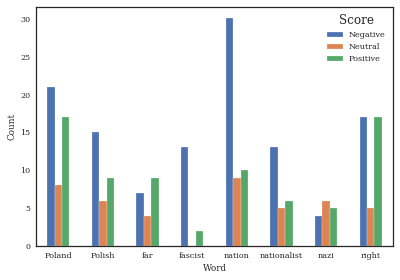

In [23]:
## Function for searching for specific words and grabbing their associated senti compound score and sentiment label

## Combine all three Reddit dataframes into one

total_reddit = pd.concat([reddit_df_senti, reddit_df_senti2, reddit_df_senti3],ignore_index=True, sort=True)

def wordSearch(word):
    df_name = total_reddit[total_reddit['body'].str.contains(word)]

    df_name = df_name[["Score"]]
    df_name = pd.DataFrame(df_name)
    df_name['Word']= word
    df_name["Compound"] = total_reddit["senti_compound"]
    
    return df_name

## Run function with chosen top words

fascist = wordSearch("fascist")
nationalist = wordSearch("nationalist")
nation = wordSearch("nation")
polish = wordSearch("Polish")
poland = wordSearch("Poland")
nazi = wordSearch("nazi")
right= wordSearch("right")
far =wordSearch("far")

   
## Concatenate dataframes which contain results of word search function for each respective top word

word_analysis = pd.concat([fascist, nationalist, nation, polish, poland, nazi, right, far], ignore_index= True, sort= True)   
#display(word_analysis)


## Plot sentiments associated with top words involved in the search above

def set_style():
    plt.style.use(['seaborn-white', 'seaborn-paper'])
    plt.rc("font", family="serif")


set_style()


word_sentiment = word_analysis.groupby(['Word', 'Score']).Score.count().unstack()
#display(word_sentiment)

word_sentiment.plot(kind='bar')

plt.xlabel("Word")
plt.ylabel("Count")
plt.xticks(rotation=0)

plt.savefig('senti.png',  dpi=1200, bbox_inches = "tight")


## Look at usage of word "right" to analyze associated sentiment scores

df_name = total_reddit[total_reddit['body'].str.contains("right")]
#display(df_name)


In [ ]:
## Plot distribution of positive, negative, and neutral comments for each Reddit post


import matplotlib.pyplot as plt

display(reddit_df_senti["Score"].value_counts())
display(reddit_df_senti2["Score"].value_counts())
display(reddit_df_senti3["Score"].value_counts())

def piePlot(df, postname):

    fig1, ax1 = plt.subplots()
    colors = ['#ff9999','#99ff99', '#ffcc99']
    explode = (.1, 0,0)
    labels = ["Negative", "Positive", "Neutral"]
    ax1.pie(df.Score.value_counts(), explode=explode, labels=labels, colors=colors, autopct='%1.1f%%',
            shadow=True, startangle=90)
    plt.title("Sentiment Breakdown of Post " + str(postname))

set_style()
piePlot(reddit_df_senti,1)
#piePlot(reddit_df_senti2,2)
#piePlot(reddit_df_senti3,3)